In [ ]:
# TODO: Redo Weighted SVR Raw
# TODO: Do unweighted SVR Processed
# TODO: Do weighted SVR Processed
# TODO: Report time spent misaligned metric

In [1]:
# import relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
from tensorflow.keras.models import load_model
from project_functions import huber_loss, huber_loss_coordinates

# PD Control Training Data

In [2]:
foldername = "test_data"

# get pd data
filepath_pd = os.path.join(foldername, 'test_pd_data.csv')
df_pd = pd.read_csv(filepath_pd)

x_pd = df_pd['cur_pos_x'].values
y_pd = df_pd['cur_pos_z'].values
ytrue = df_pd['steering_angle']

# get ground truth data
filepath_gt = os.path.join(foldername, 'gt_udem1.csv')
df_gt = pd.read_csv(filepath_gt)

x_gt = df_gt['bez_x'].values
y_gt = df_gt['bez_z'].values

## Raw Data - Unweighted

In [3]:
model_name = "unweighted_svr_model_raw_pd"

In [4]:
# get base model with raw data test results
filepath = os.path.join(foldername, f'test_{model_name}_data.csv')
df_model = pd.read_csv(filepath)

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

if len(x_pd) > len(x_model):
    x_pd = x_pd[:len(x_model)]
    y_pd = y_pd[:len(y_model)]

if len(x_gt) > len(x_model):
    x_gt = x_gt[:len(x_model)]
    y_gt = y_gt[:len(y_model)]

df_model['steering_angle'] = df_model['steering_angle'].apply(lambda x: float(x.replace('[', '').replace(']', '')))

In [5]:
# evaluate model on test data
ypred = df_model['steering_angle'].values

ytrue = ytrue[0:len(ypred)]

### Huber losses
- Testing loss
- PD coordinates loss
- Ground truth coordinates loss

In [8]:

model_test_hl = huber_loss(ypred, ytrue)

pd_xy_model_test_hl = huber_loss_coordinates(x_pd[0:len(x_model)], y_pd[0:len(y_model)], x_model, y_model)
gt_xy_model_test_hl = huber_loss_coordinates(x_gt[0:len(x_model)], y_gt[0:len(y_model)], x_model, y_model)


Model Test Huber Loss: 0.10230555438079605
PD and Model Huber Loss: 0.02929007602346814
Ground Truth and Model Huber Loss: 0.02855960368987025


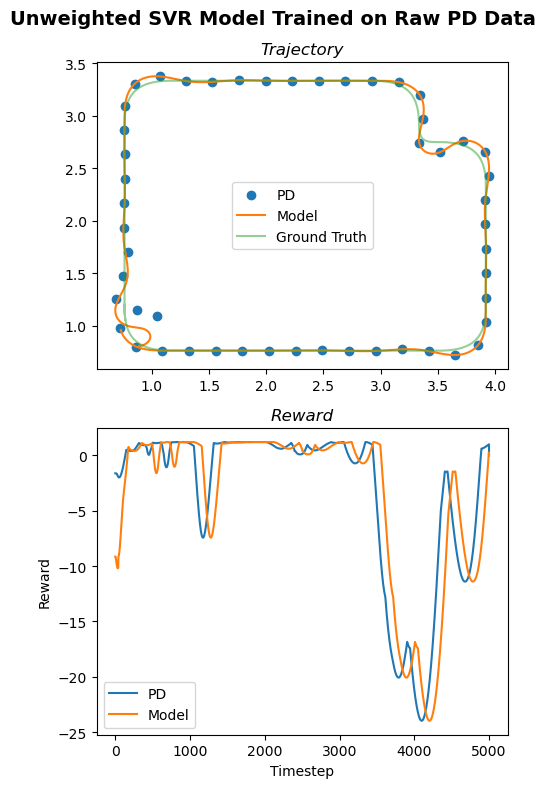

In [10]:
# plot and print data 

# create subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5,8))

fig.suptitle("Unweighted SVR Model Trained on Raw PD Data", fontsize=14, fontweight='bold')

# plot trajectories for qualitative comparison
ax1.scatter(x_pd[::100], y_pd[::100], label='PD', color='C0')
ax1.plot(x_model, y_model, label='Model', color='C1')
ax1.plot(x_gt, y_gt, label='Ground Truth', color='C2', alpha=0.5)
ax1.legend()
ax1.set_title("Trajectory", fontsize=12, fontstyle='italic')

# plot reward values for dnn and pd 
reward_model = df_model["reward"].values
reward_pd = df_pd["reward"].values

timestep_model = range(len(df_model))
timestep_pd = range(len(df_pd))

ax2.plot(timestep_pd, reward_pd, label='PD')
ax2.plot(timestep_model, reward_model, label='Model')
ax2.legend()
ax2.set_xlabel("Timestep")
ax2.set_ylabel("Reward")
ax2.set_title("Reward", fontsize=12, fontstyle='italic')

plt.tight_layout()

print(f"Model Test Huber Loss: {model_test_hl}")
print(f"PD and Model Huber Loss: {pd_xy_model_test_hl}")
print(f"Ground Truth and Model Huber Loss: {gt_xy_model_test_hl}")

/var/folders/b9/txb22f353wl_gt1f7mbxzq8h0000gn/T/ipykernel_9498/1258267068.py:15: RuntimeWarning: invalid value encountered in divide
  cosine_angle = dot_product / (magnitude1 * magnitude2)


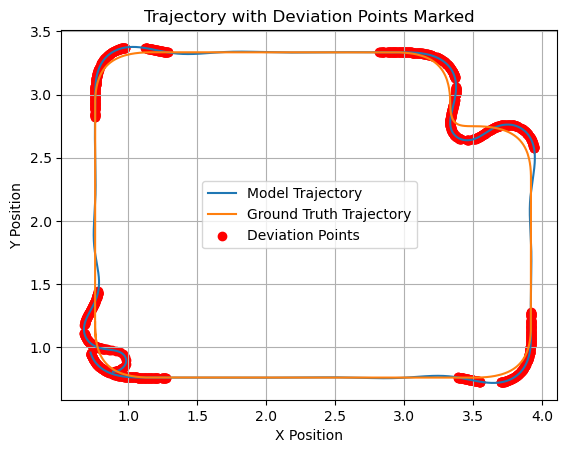

Time Spent Misaligned: 1528


In [11]:
# Calculate direction vectors
def calculate_direction_vectors(x, y):
    dx = np.diff(x)
    dy = np.diff(y)
    return dx, dy

dx_model, dy_model = calculate_direction_vectors(x_model, y_model)
dx_gt, dy_gt = calculate_direction_vectors(x_gt, y_gt)

# Calculate angles between direction vectors
def calculate_angles(dx1, dy1, dx2, dy2):
    dot_product = dx1 * dx2 + dy1 * dy2
    magnitude1 = np.sqrt(dx1**2 + dy1**2)
    magnitude2 = np.sqrt(dx2**2 + dy2**2)
    cosine_angle = dot_product / (magnitude1 * magnitude2)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))  # Clip to handle numerical issues
    return np.degrees(angle)

angles = calculate_angles(dx_model, dy_model, dx_gt, dy_gt)

# Set threshold
max_angle_deviation = 10  # Example: Maximum angle deviation in degrees

# Initialize variables
deviation_points = []

# Find points where angle deviation exceeds threshold
for i in range(len(angles)):
    if angles[i] > max_angle_deviation:
        deviation_points.append((x_model[i+1], y_model[i+1]))  # i+1 because we used np.diff

# Plot trajectory diagram with deviation points marked
plt.plot(x_model, y_model, label='Model Trajectory')
plt.plot(x_gt, y_gt, label='Ground Truth Trajectory')
deviation_points = np.array(deviation_points)
if deviation_points.size > 0:
    plt.scatter(deviation_points[:, 0], deviation_points[:, 1], color='red', label='Deviation Points')

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Trajectory with Deviation Points Marked')
plt.legend()
plt.grid(True)
plt.show()

print(f"Time Spent Misaligned: {len(deviation_points)}")

## Raw Data - Weighted

In [12]:
model_name = "weighted_svr_model_raw_pd"

In [13]:
# get base model with raw data test results
filepath = os.path.join(foldername, f'test_{model_name}_data.csv')
df_model = pd.read_csv(filepath)

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

if len(x_pd) > len(x_model):
    x_pd = x_pd[:len(x_model)]
    y_pd = y_pd[:len(y_model)]

if len(x_gt) > len(x_model):
    x_gt = x_gt[:len(x_model)]
    y_gt = y_gt[:len(y_model)]

df_model['steering_angle'] = df_model['steering_angle'].apply(lambda x: float(x.replace('[', '').replace(']', '')))

In [14]:
# evaluate model on test data
ypred = df_model['steering_angle'].values

ytrue = ytrue[0:len(ypred)]

### Huber losses
- Testing loss
- PD coordinates loss
- Ground truth coordinates loss

In [15]:

model_test_hl = huber_loss(ypred, ytrue)

pd_xy_model_test_hl = huber_loss_coordinates(x_pd[0:len(x_model)], y_pd[0:len(y_model)], x_model, y_model)
gt_xy_model_test_hl = huber_loss_coordinates(x_gt[0:len(x_model)], y_gt[0:len(y_model)], x_model, y_model)


Model Test Huber Loss: 0.18411732521456933
PD and Model Huber Loss: 1.600178799144029
Ground Truth and Model Huber Loss: 1.5909605009924086


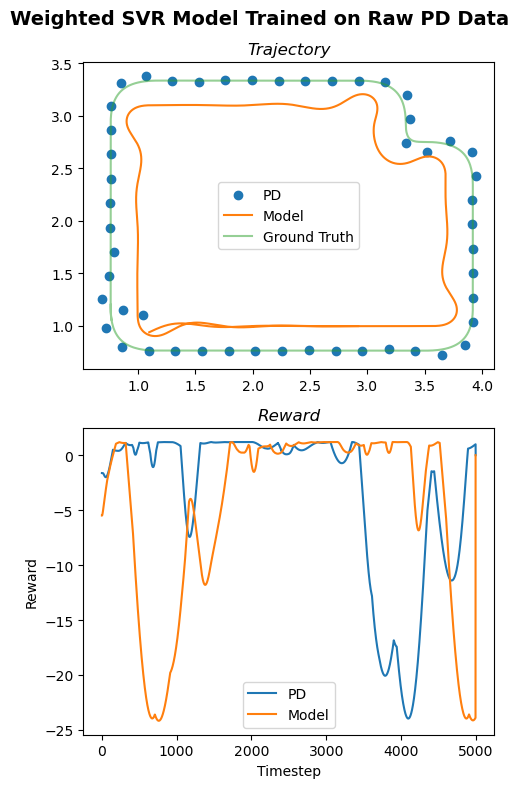

In [18]:
# plot and print data 

# create subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5,8))

fig.suptitle("Weighted SVR Model Trained on Raw PD Data", fontsize=14, fontweight='bold')

# plot trajectories for qualitative comparison
ax1.scatter(x_pd[::100], y_pd[::100], label='PD', color='C0')
ax1.plot(x_model, y_model, label='Model', color='C1')
ax1.plot(x_gt, y_gt, label='Ground Truth', color='C2', alpha=0.5)
ax1.legend()
ax1.set_title("Trajectory", fontsize=12, fontstyle='italic')

# plot reward values for dnn and pd 
reward_model = df_model["reward"].values
reward_pd = df_pd["reward"].values

timestep_model = range(len(df_model))
timestep_pd = range(len(df_pd))

ax2.plot(timestep_pd, reward_pd, label='PD')
ax2.plot(timestep_model, reward_model, label='Model')
ax2.legend()
ax2.set_xlabel("Timestep")
ax2.set_ylabel("Reward")
ax2.set_title("Reward", fontsize=12, fontstyle='italic')

plt.tight_layout()

print(f"Model Test Huber Loss: {model_test_hl}")
print(f"PD and Model Huber Loss: {pd_xy_model_test_hl}")
print(f"Ground Truth and Model Huber Loss: {gt_xy_model_test_hl}")

/var/folders/b9/txb22f353wl_gt1f7mbxzq8h0000gn/T/ipykernel_9498/1258267068.py:15: RuntimeWarning: invalid value encountered in divide
  cosine_angle = dot_product / (magnitude1 * magnitude2)


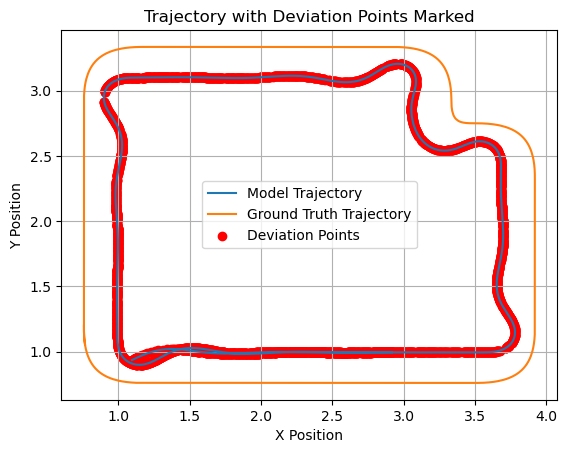

Time Spent Misaligned: 4000


In [19]:
# Calculate direction vectors
def calculate_direction_vectors(x, y):
    dx = np.diff(x)
    dy = np.diff(y)
    return dx, dy

dx_model, dy_model = calculate_direction_vectors(x_model, y_model)
dx_gt, dy_gt = calculate_direction_vectors(x_gt, y_gt)

# Calculate angles between direction vectors
def calculate_angles(dx1, dy1, dx2, dy2):
    dot_product = dx1 * dx2 + dy1 * dy2
    magnitude1 = np.sqrt(dx1**2 + dy1**2)
    magnitude2 = np.sqrt(dx2**2 + dy2**2)
    cosine_angle = dot_product / (magnitude1 * magnitude2)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))  # Clip to handle numerical issues
    return np.degrees(angle)

angles = calculate_angles(dx_model, dy_model, dx_gt, dy_gt)

# Set threshold
max_angle_deviation = 10  # Example: Maximum angle deviation in degrees

# Initialize variables
deviation_points = []

# Find points where angle deviation exceeds threshold
for i in range(len(angles)):
    if angles[i] > max_angle_deviation:
        deviation_points.append((x_model[i+1], y_model[i+1]))  # i+1 because we used np.diff

# Plot trajectory diagram with deviation points marked
plt.plot(x_model, y_model, label='Model Trajectory')
plt.plot(x_gt, y_gt, label='Ground Truth Trajectory')
deviation_points = np.array(deviation_points)
if deviation_points.size > 0:
    plt.scatter(deviation_points[:, 0], deviation_points[:, 1], color='red', label='Deviation Points')

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Trajectory with Deviation Points Marked')
plt.legend()
plt.grid(True)
plt.show()

print(f"Time Spent Misaligned: {len(deviation_points)}")